## Load the necessary libraries

In [184]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


# Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Prepare CIFAR-10 Datase

In [185]:
# Prepare Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

# Define the classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


#### Visualize few data

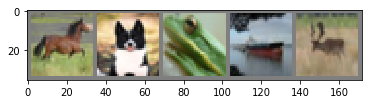

   horse      dog     frog     ship     deer


In [186]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(5)))

### Define dictonaries for different tweaks

In [226]:
# Types of activation function

activation = {
    'relu': nn.ReLU(inplace=True),
    'leakyrelu': nn.LeakyReLU(0.1, inplace=True),
    'selu': nn.SELU(inplace=True),
    'elu': nn.ELU(alpha=1.0, inplace=True),
    'celu': nn.CELU(alpha=1.0, inplace=True),
    'hardsrink': nn.Hardshrink()
}

# Types of initilization of weights

# init = {
#     'he': nn.init.xavier_normal_(tensor, gain=1.0)
#     'orth' : nn.init.orthogonal_(tensor, gain=1)
# }      

### Defining CrossEntryLoss
#### Reference: https://github.com/eladhoffer/utils.pytorch/blob/master/cross_entropy.py

In [188]:
import torch.nn.functional as F
def smooth_one_hot(true_labels: torch.Tensor, classes: int, smoothing=0.0):
    """
    if smoothing == 0, it's one-hot method
    if 0 < smoothing < 1, it's smooth method

    """
    assert 0 <= smoothing < 1
    confidence = 1.0 - smoothing
    label_shape = torch.Size((true_labels.size(0), classes))
    with torch.no_grad():
        true_dist = torch.empty(size=label_shape, device=true_labels.device)
        true_dist.fill_(smoothing / (classes - 1))
        true_dist.scatter_(1, true_labels.data.unsqueeze(1), confidence)
    return true_dist


class LabelSmoothLoss(nn.Module):
    
    def __init__(self, smoothing=0.0):
        super(LabelSmoothLoss, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

## Define the ResNet architecture

In [189]:
## Define the ResNet architecture from the paper

# Define convolution operator
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)

# Main basic block that will be repeated
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, normalize=None, activation=nn.ReLU(inplace=True), batchnorm=True):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        # we define batchnorm but filter it out in forward
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Enables us to use different type of activation
        self.activation = activation
        # Batchnorm flag
        self.batchnorm = batchnorm
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.normalize = normalize
        # self.initilize_weight()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        # Perform batchnorm if it is enabled
        if self.batchnorm:
          out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        # Perform batchnorm if it is enabled
        if self.batchnorm:
          out = self.bn2(out)
        # Change the shape of the layer to combine the residual
        if self.normalize:
            residual = self.normalize(x)
        out += residual
        out = self.activation(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, activation=nn.ReLU(inplace=True), batchnorm=True, regularization=False):
        super(ResNet, self).__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.regularization = regularization
        # First change from 3 channel input to 16 channel
        self.in_channels = 16
        # This conv layers converts RBG to 16 channel
        self.conv = conv3x3(3, 16)
        self.bn1 = nn.BatchNorm2d(16)
        # Create residual basic blocks
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        # Dropout
        self.drop = nn.Dropout(0.5)


    def make_layer(self, block, out_channels, blocks, stride=1):
        normalize = None
        
        # Define a layer to adjust the shape so residue can be added
        if (stride != 1) or (self.in_channels != out_channels):
            normalize = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        # Holds the basic residue block
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, normalize, self.activation, self.batchnorm))
        self.in_channels = out_channels
        
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, 1, None, self.activation, self.batchnorm))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        
        # Perform batchnorm if it is enabled
        if self.batchnorm:
          out = self.bn1(out)

        out = self.layer1(out)
        # Perform regularization
        if self.regularization:
          out = self.drop(out)
        out = self.layer2(out)
        # Perform regularization
        if self.regularization:
          out = self.drop(out)        
        out = self.layer3(out)
        # Perform regularization
        if self.regularization:
          out = self.drop(out)         
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### Define hyper-parameters

In [219]:
# Setting weights to ortho
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        nn.init.orthogonal_(m.weight)
        try:
            nn.init.orthogonal_(m.weight)
        except:
            nn.init.zeros_(m.bias)


class ResNetHPara:
  def __init__(self, activation=activation['relu'], batchnorm=False, labelSmooth=False, 
               learningRate='constant', regularization=False, init='he', 
               name='baseline', epoch=10):
    # batch_size, epoch and iteration
    self.batch_size = 256
    self.num_epochs = epoch
    self.name = name
    self.learningRate = learningRate
    self.labelSmooth = labelSmooth
    # Create ResNet
    net_args = {
        "block": BasicBlock,
        "layers": [2, 2, 2, 2],
        "activation": activation,
        "batchnorm": batchnorm,
        "regularization": regularization
    }
    self.model = ResNet(**net_args)

    if init == 'ortho':
        for name, module in self.model.named_children():
            module.apply(weights_init)

    # Move the model to CUDA
    self.model.to(device)
        
    if not labelSmooth:
        # Cross Entropy Loss 
        self.error = nn.CrossEntropyLoss()
    else:
        # from torch.utils.cross_entropy import CrossEntropyLoss
        # self.error = CrossEntropyLoss(smooth_eps=0.95)
        self.error = LabelSmoothLoss(smoothing=0.1)
        # self.error = nn.BCEWithLogitsLoss()
    
    # Adam Optimizer
    learning_rate = 0.001

    if self.learningRate == 'constant':
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    else:
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.1, momentum=0.9)
        self.schedular = torch.optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=0.01, max_lr=0.1)       


    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    self.train_loader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size,
                                              shuffle=True, num_workers=4)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)

    self.test_loader = torch.utils.data.DataLoader(testset, batch_size=self.batch_size,
                                            shuffle=False, num_workers=4)


  def train(self):
    self.loss_list = []
    self.iteration_list = []
    self.accuracy_list = []
    count = 0
    for epoch in range(self.num_epochs):
        for i, (images, labels) in enumerate(self.train_loader):
            train = Variable(images).to(device)
            labels = Variable(labels).to(device)           
            # Clear gradients
            self.optimizer.zero_grad()    
            # Forward propagation
            outputs = self.model(train)        
            # Calculate softmax and ross entropy loss
            if not self.labelSmooth:
              loss = self.error(outputs, labels)        
            else:
              # smooth_label = smooth_one_hot(labels, classes=10, smoothing=0.9)
              loss = self.error(outputs, labels)
            # Calculating gradients
            loss.backward()        
            # Update parameters
            if self.learningRate == 'constant':
              self.optimizer.step()      
            else:
              self.optimizer.step()
              self.schedular.step()  
            count += 1      
            if count % 100 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in self.test_loader:               
                    # Inference
                    images = Variable(images).to(device)
                    labels = Variable(labels).to(device)  
                    outputs = self.model(images)                
                    # Get predictions
                    predicted = torch.max(outputs.data, 1)[1]             
                    # Total number of labels
                    total += labels.size(0)              
                    correct += (predicted == labels).sum()         
                accuracy = 100 * correct / float(total)         
                # store loss and iteration
                self.loss_list.append(loss.data)
                self.iteration_list.append(count)
                self.accuracy_list.append(accuracy)
                # if count % 100 == 0:
                #    # Print Loss
                #    print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
        # Save the model in each epoch
        torch.save({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': loss,
                }, '/tmp/cifar10-'+self.name+'-.pth')


  def count_parameters(self, grad):
      if grad:
          return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
      else:
          return sum(p.numel() for p in self.model.parameters())

      print('Total Parameters: ', count_parameters(self.model, False))
      print('Total Trainable Parameters: ', count_parameters(self.model, True))

## Train the ResNet model

In [33]:
# Baseline
baseline_model_args = {
  'activation':activation['relu'], 'batchnorm':False, 'labelSmooth':False, 
  'learningRate':'constant', 'regularization':False, 'init':'he', 'name':'baseline'
}

# LeakyRelu
leakyrelu_model_args = {
  'activation':activation['leakyrelu'], 'batchnorm':False, 'labelSmooth':False, 
  'learningRate':'constant', 'regularization':False, 'init':'he', 'name':'LRelu'
}

# Selu
selu_model_args = {
  'activation':activation['selu'], 'batchnorm':False, 'labelSmooth':False, 
  'learningRate':'constant', 'regularization':False, 'init':'he', 'name':'Selu'
}

# Elu
elu_model_args = {
  'activation':activation['elu'], 'batchnorm':False, 'labelSmooth':False, 
  'learningRate':'constant', 'regularization':False, 'init':'he', 'name':'Elu'
}

# Celu
celu_model_args = {
  'activation':activation['celu'], 'batchnorm':False, 'labelSmooth':False, 
  'learningRate':'constant', 'regularization':False, 'init':'he', 'name':'Celu'
}

# BatchNorm
bn_model_args = {
  'activation':activation['relu'], 'batchnorm':True, 'labelSmooth':False, 
  'learningRate':'constant', 'regularization':False, 'init':'he', 'name':'BatchNorm'
}

# LabelSmooth ## Not working yet
label_model_args = {
  'activation':activation['relu'], 'batchnorm':False, 'labelSmooth':True, 
  'learningRate':'constant', 'regularization':False, 'init':'he', 'name':'LableSmooth'
}

# LearningRate
clr_model_args = {
  'activation':activation['relu'], 'batchnorm':False, 'labelSmooth':False, 
  'learningRate':'cyclic', 'regularization':False, 'init':'he', 'name':'CLR'
}

# Regularization
dropout_model_args = {
  'activation':activation['relu'], 'batchnorm':False, 'labelSmooth':False, 
  'learningRate':'constant', 'regularization':True, 'init':'he', 'name':'Dropout'
}


# Init  ## Not working yet
othro_model_args = {
  'activation':activation['relu'], 'batchnorm':False, 'labelSmooth':False, 
  'learningRate':'constant', 'regularization':False, 'init':'ortho', 'name':'Ortho'
}


args_list = [baseline_model_args, leakyrelu_model_args, selu_model_args, elu_model_args, 
             celu_model_args, bn_model_args, clr_model_args, dropout_model_args,
            label_model_args, othro_model_args]

# args_list = [label_model_args, othro_model_args]
# from joblib import Parallel, delayed

def train(para):
  data = []
  for i in range(10):
    model = ResNetHPara(**para)
    model.train()
    data.append(max(model.accuracy_list).data.tolist())

  return data

# Parallel(n_jobs=2)(delayed(train)(para) for para in args_list)
import pickle

models = []
for para in args_list:
    print(para)
    models.append(train(para))

with open('/tmp/modelsdata.pi', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)
    

{'activation': ReLU(inplace=True), 'batchnorm': False, 'labelSmooth': True, 'learningRate': 'constant', 'regularization': False, 'init': 'he', 'name': 'LableSmooth'}
Files already downloaded and verified
Files already downloaded and verified
Iteration: 100  Loss: 1.726982831954956  Accuracy: 43.16999816894531 %
Iteration: 200  Loss: 1.4858973026275635  Accuracy: 53.5 %
Iteration: 300  Loss: 1.374246597290039  Accuracy: 57.6099967956543 %
Iteration: 400  Loss: 1.371036410331726  Accuracy: 60.7599983215332 %
Iteration: 500  Loss: 1.3710182905197144  Accuracy: 63.679996490478516 %
Iteration: 600  Loss: 1.1757255792617798  Accuracy: 67.23999786376953 %
Iteration: 700  Loss: 1.1822865009307861  Accuracy: 68.0999984741211 %
Iteration: 800  Loss: 1.1736226081848145  Accuracy: 70.4000015258789 %
Iteration: 900  Loss: 1.2245560884475708  Accuracy: 70.29999542236328 %
Iteration: 1000  Loss: 1.1261379718780518  Accuracy: 72.12999725341797 %
Iteration: 1100  Loss: 1.1226766109466553  Accuracy: 73.

### Box plot

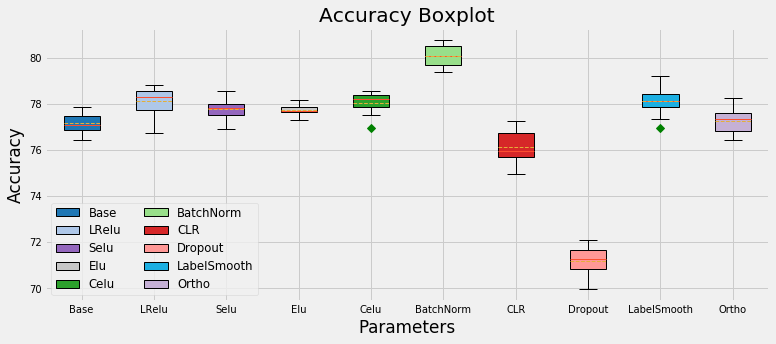

In [46]:
#data = pickle.load( open( "/tmp/modelsdata1.pi", "rb" ) )
#data1 = pickle.load( open( "/tmp/modelsdata2.pi", "rb" ) )
# data += data1
data = pickle.load( open( "/tmp/modelsdata.pi", "rb" ) )


plt.style.use('fivethirtyeight')

# data = [d.data.tolist() for d in data[0]]

import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)
names = ['Baseline', 'LRelu', 'Selu', 'Elu', 'Celu','BatchNorm','CLR','Dropout','LabelSmooth','Ortho']

color_sequence = [
    '#1f77b4', '#aec7e8', '#9467bd', '#c7c7c7', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#1cafe2', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#ffbb78', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
    '#9caae5', '#ff7f0e']

medianprops = dict(linewidth=2, color='firebrick')
meanprops = dict(linewidth=2, color='#ff7f0e')    

fig1, ax1 = plt.subplots(figsize=(11,5))

bp1 = ax1.boxplot(data, 0, 'gD', showmeans=True, meanline=True,
            patch_artist=True, widths=0.5)

for patch, color in zip(bp1['boxes'], color_sequence):
    patch.set_facecolor(color)

plt.xticks(range(1, 11), names)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xlabel('Parameters', fontsize="large")
ax1.set_ylabel('Max Accuracy', fontsize="large")
ax1.legend(zip(bp1['boxes']), names, fontsize="small", loc="lower left",ncol=2)
ax1.set_title('Accuracy Boxplot')
plt.tight_layout()

plt.show()

### Histogram

In [48]:
baseline_model_args = {'epoch':20, 'name':'baseline'}

# LeakyRelu
leakyrelu_model_args = {'activation':activation['leakyrelu'], 'name':'LRelu', 'epoch':20}

# Selu
selu_model_args = {'activation':activation['selu'], 'name':'Selu', 'epoch':20}

# Elu
elu_model_args = {
  'activation':activation['elu'], 'name':'Elu', 'epoch':20}

# Celu
celu_model_args = {
  'activation':activation['celu'], 'name':'Celu', 'epoch':20}

# BatchNorm
bn_model_args = {'batchnorm':True,'name':'BatchNorm', 'epoch':20}

# LabelSmooth
label_model_args = {
  'labelSmooth':True, 'name':'LableSmooth', 'epoch':20 }

# LearningRate
clr_model_args = { 'learningRate':'cyclic', 'name':'CLR', 'epoch':20 }

# Regularization
dropout_model_args = {'regularization':True, 'name':'Dropout', 'epoch':20 }


# Init 
othro_model_args = { 'init':'ortho', 'name':'Ortho', 'epoch':20 }

args_list = [baseline_model_args, leakyrelu_model_args, selu_model_args, elu_model_args, 
             celu_model_args, bn_model_args, clr_model_args, dropout_model_args,
            label_model_args, othro_model_args]

def trainonce(para):
  data = []
  for i in range(1):
    model = ResNetHPara(**para)
    model.train()
    data.append(max(model.accuracy_list).data.tolist())

  return data


for para in args_list:
    print(para)
    models.append(trainonce(para))

with open('/tmp/modelsdatahistogram.pi', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

{'epoch': 20, 'name': 'baseline'}
Files already downloaded and verified
Files already downloaded and verified
Iteration: 100  Loss: 1.4749637842178345  Accuracy: 40.939998626708984 %
Iteration: 200  Loss: 1.2583059072494507  Accuracy: 49.69999694824219 %
Iteration: 300  Loss: 1.2854958772659302  Accuracy: 57.119998931884766 %
Iteration: 400  Loss: 1.0030407905578613  Accuracy: 60.369998931884766 %
Iteration: 500  Loss: 0.9924841523170471  Accuracy: 63.429996490478516 %
Iteration: 600  Loss: 1.0223106145858765  Accuracy: 65.6199951171875 %
Iteration: 700  Loss: 0.8057418465614319  Accuracy: 67.65999603271484 %
Iteration: 800  Loss: 0.8236149549484253  Accuracy: 68.25 %
Iteration: 900  Loss: 0.8127089738845825  Accuracy: 71.00999450683594 %
Iteration: 1000  Loss: 0.8136852979660034  Accuracy: 70.06999969482422 %
Iteration: 1100  Loss: 0.7285128831863403  Accuracy: 71.95999908447266 %
Iteration: 1200  Loss: 0.613781750202179  Accuracy: 72.73999786376953 %
Iteration: 1300  Loss: 0.78869414

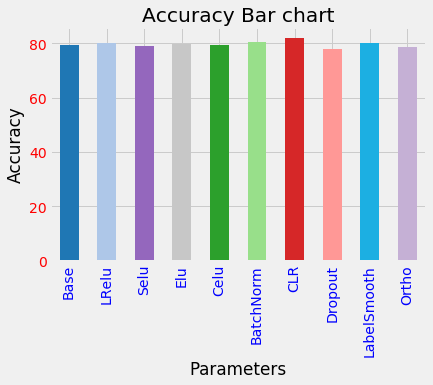

In [84]:
data = pickle.load( open( "/tmp/modelsdatahistogram.pi", "rb" ) )
data = [data[i][0] for i in range(3,13)]
t = range(0, 50, 5)

s = pd.Series(
    data,
    index = names
)

#Set descriptions:
plt.title("Accuracy Bar chart")
plt.ylabel('Accuracy')
plt.xlabel('Parameters')

#Set tick colors:
ax = plt.gca()
ax.tick_params(axis='x', colors='blue')
ax.tick_params(axis='y', colors='red')

#Plot the data:
my_colors = 'rgbkymc'  #red, green, blue, black, etc.

s.plot( 
    kind='bar', 
    color=color_sequence
)

plt.show()

## Conclusions from independent tweaks

Based on the bar chart and error plot, performing **BatchNorm** has sifinicant impact on the accuracy of the ResNet18 when trained for 10 epochs. Initial results suggest that, the parameter tweaking depends largely on the number of epochs completed. Since we have limited computation resource, we trained the networks for 10 epochs to get the error bars.  Bar chart give a different story about the right parameter that the box plot. According to bar chart, CLR seems to perfrom better than baseline and all others.

# Part 2


## Genetic Algorithm to Find Best parameter

Genetic algorithms are good to search a irregular search space. Since the parameter search space for the neural network is complicated, it worth a try to use a genetci algorithm to find a parameter set that performs better than other parameter set. There are lots of paper using genetic algorithm to find the best activation function or using genetic algorithm instead of backprop. So we think genetic algorithm is a good choice to explore the parameter space.

In [237]:
# from random import randint, random
from operator import add
import numpy as np
nprandom = np.random.RandomState()


activation_name = ['relu', 'leakyrelu', 'selu', 'elu', 'celu', 'hardsrink']
        
# Store the genome that has already been computed    
cache_genome = {}

def create_random_genome():
    genome = [0]*6
    for i in range(len(genome)):
        if i == 0:
            genome[0] = nprandom.choice([0,1,2,3,4])
        else:
            genome[i] = nprandom.choice([0, 1])
    return ''.join(map(str, genome))
    
    
def create_para_genome(genome):
    default_paras = {
        'activation':activation['relu'], 'batchnorm':False, 'labelSmooth':False, 
      'learningRate':'constant', 'regularization':False, 'init':'he', 'name':'baseline',
        'epoch':15
    }
    default_paras['activation'] = activation[activation_name[int(genome[0])]]
    default_paras['batchnorm'] = bool(genome[1])
    default_paras['learningRate'] = 'constant' if bool(genome[2]) else 'CLR'
    default_paras['regularization'] = bool(genome[3])
    default_paras['labelSmooth'] = bool(genome[4])
    default_paras['init'] = 'he' if bool(genome[5]) else 'ortho'
    default_paras['name'] = genome #''.join(map(str, genome))
    return default_paras    
    
    
def individual():
    'Create a member of the population.'
    # para = create_para_genome(create_random_genome())
    # return [ResNetHPara(**para)]
    return create_random_genome()
    

def population(count=10):
    """
    Create a number of individuals (i.e. a population).
    count: the number of individuals in the population
    """
    temp_genome_set = []
    while True:
        temp_genome_set += [individual() for x in range(count)]
        # print(temp_genome_set)
        temp_genome_set = set(temp_genome_set)
        bar = temp_genome_set.copy()
        for g in temp_genome_set:
            if g in cache_genome.keys():
                bar.remove(g)
        temp_genome_set = list(bar)
        if len(temp_genome_set) >= count:
            return temp_genome_set[:count]


def fitness(individual, target=85.0):
    """
    Determine the fitness of an individual. Higher is better.
    Initialized the network based on the genome. Then run the network
    on CIFAR10 dataset. Use the max accuracy as fitness function.
    
    individual: the individual to evaluate
    target: the target accuracy we are aiming for
    """
    # sum = reduce(add, individual, 0)
    try:
        fitness = cache_genome[individual]
    except KeyError:
        para = create_para_genome(create_random_genome())
        print(para)
        model = ResNetHPara(**para)
        model.train()
        fitness = max(model.accuracy_list).data.tolist()
        cache_genome[individual] = fitness
    return fitness


def grade(pop, target):
    'Find average fitness for a population.'
    allfitness = [fitness(x, target) for x in pop]
    return sum(allfitness) / (len(pop) * 1.0)


def evolve(pop, target=10, retain=0.2, random_select=0.3, mutate=0.3):
    graded = [ (fitness(x, target), x) for x in pop]
    graded = [ x[1] for x in sorted(graded, reverse=True)]
    retain_length = int(len(graded)*retain)
    parents = graded[:retain_length]
    
    # randomly add other individuals to
    # promote genetic diversity
    for individual in graded[retain_length:]:
        if random_select > nprandom.rand():
            parents.append(individual)
    
    # mutate some individuals
    for individual in parents:
        if mutate > nprandom.rand():
            pos_to_mutate = nprandom.randint(0, len(individual)-1)
            temp = list(individual)
            if pos_to_mutate == 0:
                choice = ['0','1','2','3','4','5']
                choice.remove(temp[pos_to_mutate])
                temp[0] = nprandom.choice(choice)
            else:
                choice = ['0', '1']
                choice.remove(temp[pos_to_mutate])
                temp[pos_to_mutate] = nprandom.choice(choice)
            individual = ''.join(map(str, temp))
    
    # crossover parents to create children
    parents_length = len(parents)
    desired_length = len(pop) - parents_length
    children = []
    while len(children) < desired_length:
        male = nprandom.randint(0, parents_length)
        female = nprandom.randint(0, parents_length)
        if male != female:
            male = parents[male]
            female = parents[female]
            point = np.random.randint(1, len(male))
            child = male[:point] + female[point:]
            if child in cache_genome.keys():
                pass
            else:
                children.append(child)        
    parents.extend(children)
    return parents



### Run the genetic algorithm

In [238]:
pop = population(10)
# print(grade(pop, 10))

i = 0
while True:
    pop = evolve(pop, target=100.0)
    for k, v in cache_genome.items():
        if v >= 0.85:
            print('Winning Configuration', k, v)
            break
    if i >=5:
        break
    i += 1
        
print(grade(pop, 10))


{'activation': CELU(alpha=1.0, inplace=True), 'batchnorm': True, 'labelSmooth': True, 'learningRate': 'constant', 'regularization': True, 'init': 'he', 'name': '410110', 'epoch': 15}
Files already downloaded and verified
Files already downloaded and verified
{'activation': LeakyReLU(negative_slope=0.1, inplace=True), 'batchnorm': True, 'labelSmooth': True, 'learningRate': 'constant', 'regularization': True, 'init': 'he', 'name': '111110', 'epoch': 15}
Files already downloaded and verified
Files already downloaded and verified
{'activation': SELU(inplace=True), 'batchnorm': True, 'labelSmooth': True, 'learningRate': 'constant', 'regularization': True, 'init': 'he', 'name': '210011', 'epoch': 15}
Files already downloaded and verified
Files already downloaded and verified
{'activation': LeakyReLU(negative_slope=0.1, inplace=True), 'batchnorm': True, 'labelSmooth': True, 'learningRate': 'constant', 'regularization': True, 'init': 'he', 'name': '101010', 'epoch': 15}
Files already downloade

### Find the best genome from the genome cache

In [252]:
# print(cache_genome)
best_genome = None
score = 0.0
for k, v in cache_genome.items():
    if v > score:
        best_genome = k
        score = v

print('Accuracy: ', cache_genome[best_genome],', Best Genome:', best_genome)        

Accuracy:  80.50999450683594 , Best Genome: 111000


## Best Configuration from Evolution Algorithm

In [257]:
best_para = create_para_genome(best_genome)
best_para

{'activation': LeakyReLU(negative_slope=0.1, inplace=True),
 'batchnorm': True,
 'labelSmooth': True,
 'learningRate': 'constant',
 'regularization': True,
 'init': 'he',
 'name': '111000',
 'epoch': 15}

In [258]:
print('Best Configuretion with 15 epoch:'), 
print('Activation:LeakyRelu')
print('BatchNorm: On')
print('Label Smoothing: On')
print('Learning Rate: Constant')
print('Dropout: True')
print('Initilization: Xavier')

Best Configuretion with 15 epoch:
Activation:LeakyRelu
BatchNorm: On
Label Smoothing: On
Learning Rate: Constant
Dropout: True
Initilization: Xavier


### Run a network with best parameters found via genetic algorithm

In [259]:
best_para['epoch'] = 25
best_model = ResNetHPara(**best_para)
best_model.train()


Files already downloaded and verified
Files already downloaded and verified


### Results

In [260]:
plt.style.use('fivethirtyeight')

# Ploting the train loss
def plot_both_loss(loss, acc, ite):
  # x = range(len(loss))
  fig, ax = plt.subplots(nrows=2, ncols=1)
  fig.set_size_inches(11, 8)

  x = ite
  ax[0].plot(x, loss, 'r', label='Training loss' )
  ax[0].set_xlabel('Iteration')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss per Iteration')
  ax[0].legend()

  ax[1].plot(x, acc, 'g', label='Training Accuracy' )
  ax[1].set_xlabel('Iteration')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Accuracy per Iteration')
  ax[1].legend()

  plt.tight_layout()
  plt.show()

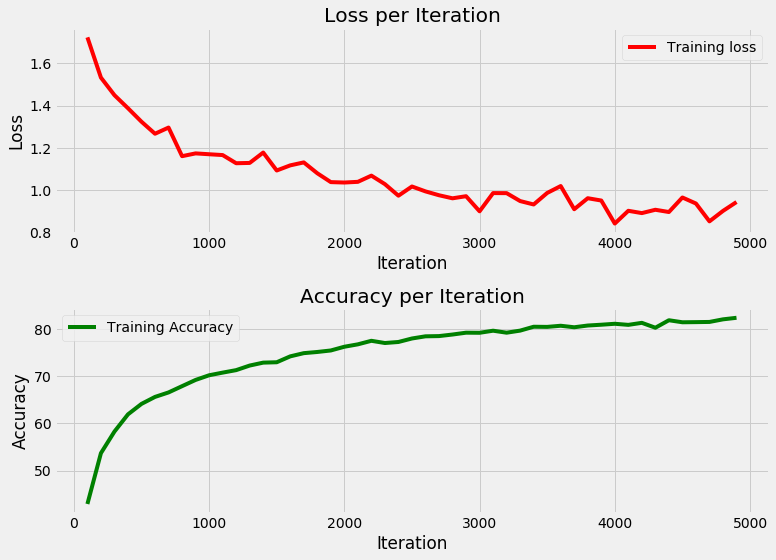

In [261]:
plot_both_loss(best_model.loss_list, best_model.accuracy_list, best_model.iteration_list)